In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
#Loading Data
with open("./tmp/sarcasm.json","r") as f:
    datastore=json.load(f)

sentences=[]
labels=[]
for item in datastore:
    sentences.append(item["headline"])
    labels.append(item["is_sarcastic"])
    

In [3]:
#defining Constants
vocab_size=10000
embedding_dims=16
max_length=120
trunc_type="post"
padding_type="post"
oov_tok="<OOV>"
training_size=20000
num_epochs=50

training_sentences=sentences[:training_size]
training_labels=labels[:training_size]
testing_sentences=sentences[training_size:]
testing_labels=labels[training_size:]

In [4]:
#Tokenizing and Padding
tokenizer=Tokenizer(num_words=vocab_size,oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index=tokenizer.word_index

training_sequences=tokenizer.texts_to_sequences(training_sentences)
training_padded=pad_sequences(training_sequences,maxlen=max_length,padding=padding_type)

testing_sequences=tokenizer.texts_to_sequences(testing_sentences)
testing_padded=pad_sequences(testing_sequences,maxlen=max_length,padding=padding_type)

In [5]:
#Model defination
model=tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size,embedding_dims,input_length=max_length),
    tf.keras.layers.Conv1D(128,5,activation="relu"),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(24,activation="relu"),
    tf.keras.layers.Dense(1,activation="sigmoid")
])

model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
conv1d (Conv1D)              (None, 116, 128)          10368     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 24)                3096      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 173,489
Trainable params: 173,489
Non-trainable params: 0
_________________________________________________________________


In [6]:
training_padded=np.array(training_padded)
training_labels=np.array(training_labels)
testing_padded=np.array(testing_padded)
testing_labels=np.array(testing_labels)

history=model.fit(training_padded,training_labels,epochs=num_epochs,validation_data=(testing_padded, testing_labels), verbose=1)

Epoch 1/50
625/625 [==============================] - 13s 20ms/step - accuracy: 0.7811 - loss: 0.4412 - val_loss: 0.3551 - val_accuracy: 0.8462
Epoch 2/50
625/625 [==============================] - 12s 18ms/step - accuracy: 0.9089 - loss: 0.2257 - val_loss: 0.3683 - val_accuracy: 0.8486
Epoch 3/50
625/625 [==============================] - 12s 19ms/step - accuracy: 0.9614 - loss: 0.1123 - val_loss: 0.4778 - val_accuracy: 0.8365
Epoch 4/50
625/625 [==============================] - 12s 19ms/step - accuracy: 0.9855 - loss: 0.0470 - val_loss: 0.5846 - val_accuracy: 0.8368
Epoch 5/50
625/625 [==============================] - 12s 19ms/step - accuracy: 0.9954 - loss: 0.0177 - val_loss: 0.7459 - val_accuracy: 0.8334
Epoch 6/50
625/625 [==============================] - 12s 19ms/step - accuracy: 0.9987 - loss: 0.0061 - val_loss: 0.8280 - val_accuracy: 0.8319
Epoch 7/50
625/625 [==============================] - 11s 18ms/step - accuracy: 0.9991 - loss: 0.0034 - val_loss: 0.9322 - val_accuracy:

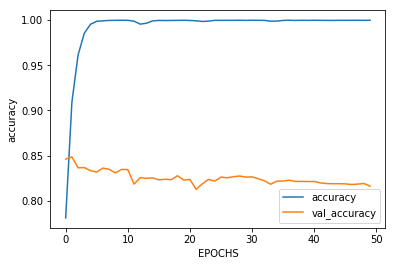

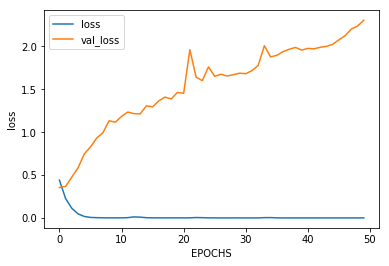

In [7]:
def plot_graph(history,string):
    plt.plot(history.history[string])
    plt.plot(history.history["val_"+string])
    plt.xlabel("EPOCHS")
    plt.ylabel(string)
    plt.legend([string,'val_'+string])
    plt.show()
    
plot_graph(history,"accuracy")
plot_graph(history,"loss")

In [8]:
model.save("sarcasm.h5")

In [11]:
reverse_word_index=dict([(value,key) for (key,value) in word_index.items()])

def decode_sentence(text):
    return " ".join([reverse_word_index.get(i,'?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

former <OOV> store clerk sues over secret 'black <OOV> for minority shoppers ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [13]:
e=model.layers[0]
weights=e.get_weights()[0]
print(weights.shape)

(10000, 16)


In [14]:
import io

out_v=io.open("vecs.tsv","w",encoding="utf-8")
out_m=io.open("meta.tsv","w",encoding="utf-8")
for word_num in range(1,vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [15]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

[[1.9474541e-01]
 [1.3531869e-17]]
